In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset And Dataloader

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [13]:
bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])  #  Transform image ke hitam putih dan juga tensor dataset

train_set = datasets.ImageFolder("data/train", transform=transform) # Membaca image folder dan melakukan transform
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)
  
test_set = datasets.ImageFolder("data/test", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

In [14]:
images, label = next(iter(trainloader))
images.shape

torch.Size([128, 1, 28, 28])

In [15]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur dan COnfig

In [9]:
from jcopdl.layers import linear_block

In [5]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation='lsoftmax'), 
        )
        
    def forward(self, x):
        return self.fc(x)

In [8]:
config = set_config({
    "input_size" : 784,
    "n1" : 256,
    "n2" : 64,
    "output_size" : len(train_set.classes),
    "dropout" : 0.2
})

# Training Preparation -> MCOC

In [9]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [10]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) # Feedforward
        loss = criterion(output, target) # Hitung Loss
        
        if mode == "train": # Backprop hanya terjadi untuk data train atau mode == train
            loss.backward()
            optimizer.step() # Update Weight
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch     1
Train_cost  = 0.7262 | Test_cost  = 0.4533 | Train_score = 0.7409 | Test_score = 0.8366 |


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:03<?, ?it/s]


Epoch     2
Train_cost  = 0.4668 | Test_cost  = 0.4018 | Train_score = 0.8349 | Test_score = 0.8580 |


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:03<?, ?it/s]


Epoch     3
Train_cost  = 0.4171 | Test_cost  = 0.3755 | Train_score = 0.8507 | Test_score = 0.8600 |


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch     4
Train_cost  = 0.3897 | Test_cost  = 0.3560 | Train_score = 0.8599 | Test_score = 0.8686 |


Train:   0%|          | 0/313 [00:02<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch     5
Train_cost  = 0.3640 | Test_cost  = 0.3459 | Train_score = 0.8701 | Test_score = 0.8718 |


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch     6
Train_cost  = 0.3532 | Test_cost  = 0.3383 | Train_score = 0.8726 | Test_score = 0.8772 |


Train:   0%|          | 0/313 [00:02<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch     7
Train_cost  = 0.3376 | Test_cost  = 0.3335 | Train_score = 0.8796 | Test_score = 0.8796 |


Train:   0%|          | 0/313 [00:02<?, ?it/s]

Test:   0%|          | 0/157 [00:03<?, ?it/s]


Epoch     8
Train_cost  = 0.3268 | Test_cost  = 0.3384 | Train_score = 0.8810 | Test_score = 0.8733 |
==> EarlyStop patience =  1 | Best test_score: 0.8796


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:03<?, ?it/s]


Epoch     9
Train_cost  = 0.3159 | Test_cost  = 0.3377 | Train_score = 0.8845 | Test_score = 0.8753 |
==> EarlyStop patience =  2 | Best test_score: 0.8796


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:03<?, ?it/s]

Train:   0%|          | 0/313 [00:02<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch    10
Train_cost  = 0.3087 | Test_cost  = 0.3243 | Train_score = 0.8878 | Test_score = 0.8820 |

Epoch    11
Train_cost  = 0.3013 | Test_cost  = 0.3199 | Train_score = 0.8901 | Test_score = 0.8848 |


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:03<?, ?it/s]


Epoch    12
Train_cost  = 0.2951 | Test_cost  = 0.3463 | Train_score = 0.8920 | Test_score = 0.8742 |
==> EarlyStop patience =  1 | Best test_score: 0.8848


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch    13
Train_cost  = 0.2862 | Test_cost  = 0.3206 | Train_score = 0.8948 | Test_score = 0.8837 |
==> EarlyStop patience =  2 | Best test_score: 0.8848


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch    14
Train_cost  = 0.2789 | Test_cost  = 0.3218 | Train_score = 0.8980 | Test_score = 0.8840 |
==> EarlyStop patience =  3 | Best test_score: 0.8848


Train:   0%|          | 0/313 [00:02<?, ?it/s]

Test:   0%|          | 0/157 [00:03<?, ?it/s]


Epoch    15
Train_cost  = 0.2740 | Test_cost  = 0.3213 | Train_score = 0.8996 | Test_score = 0.8818 |
==> EarlyStop patience =  4 | Best test_score: 0.8848


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch    16
Train_cost  = 0.2660 | Test_cost  = 0.3168 | Train_score = 0.9016 | Test_score = 0.8853 |


Train:   0%|          | 0/313 [00:02<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch    17
Train_cost  = 0.2613 | Test_cost  = 0.3250 | Train_score = 0.9046 | Test_score = 0.8842 |
==> EarlyStop patience =  1 | Best test_score: 0.8853


Train:   0%|          | 0/313 [00:02<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch    18
Train_cost  = 0.2570 | Test_cost  = 0.3068 | Train_score = 0.9050 | Test_score = 0.8911 |


Train:   0%|          | 0/313 [00:02<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch    19
Train_cost  = 0.2542 | Test_cost  = 0.3125 | Train_score = 0.9060 | Test_score = 0.8874 |
==> EarlyStop patience =  1 | Best test_score: 0.8911


Train:   0%|          | 0/313 [00:02<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch    20
Train_cost  = 0.2476 | Test_cost  = 0.3047 | Train_score = 0.9080 | Test_score = 0.8911 |


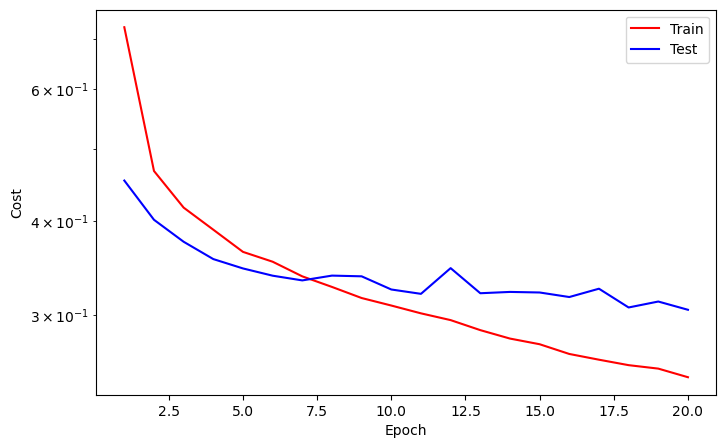

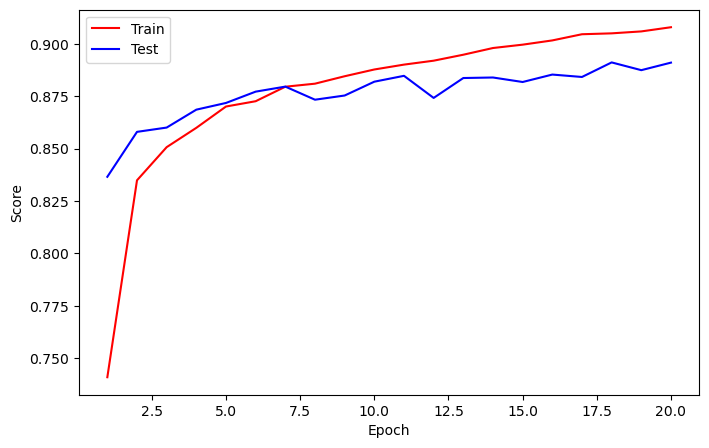

==> EarlyStop patience =  2 | Best test_score: 0.8911


Train:   0%|          | 0/313 [00:02<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch    21
Train_cost  = 0.2430 | Test_cost  = 0.3199 | Train_score = 0.9103 | Test_score = 0.8860 |
==> EarlyStop patience =  3 | Best test_score: 0.8911


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:03<?, ?it/s]


Epoch    22
Train_cost  = 0.2402 | Test_cost  = 0.3375 | Train_score = 0.9103 | Test_score = 0.8825 |
==> EarlyStop patience =  4 | Best test_score: 0.8911


Train:   0%|          | 0/313 [00:03<?, ?it/s]

Test:   0%|          | 0/157 [00:02<?, ?it/s]


Epoch    23
Train_cost  = 0.2364 | Test_cost  = 0.3204 | Train_score = 0.9104 | Test_score = 0.8865 |
==> EarlyStop patience =  5 | Best test_score: 0.8911
==> Execute Early Stopping at epoch: 23 | Best test_score: 0.8911
==> Best model is saved at model


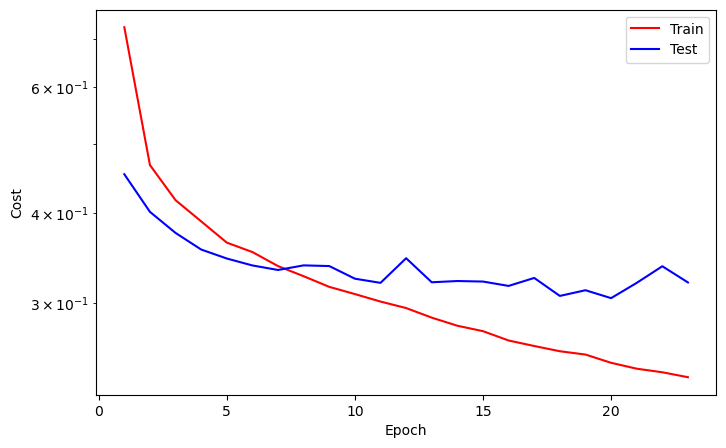

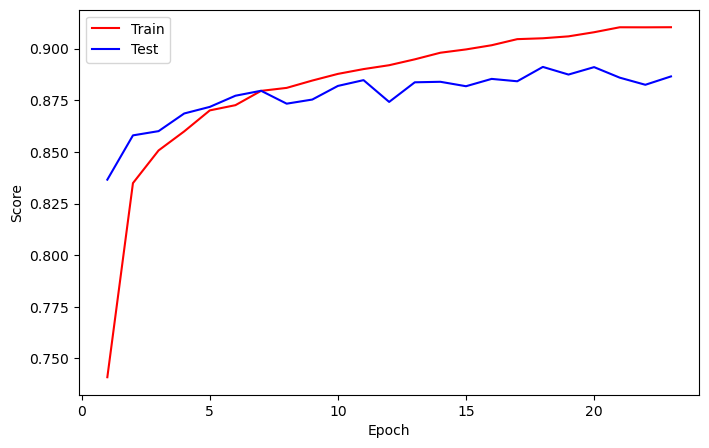

In [11]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [12]:
import jcopdl

jcopdl.__version__

'1.1.1'

# Load Best Model

In [10]:
weights = torch.load("model/weights_best.pth", map_location="cpu")
config = torch.load("model/configs.pth", map_location="cpu")

model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
model.load_state_dict(weights)
model = model.to(device)

# Predict

In [16]:
feature , target = next(iter(testloader))
feature , target = feature.to(device), target.to(device)

In [18]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['Sneaker',
 'Dress',
 'Trouser',
 'Shirt',
 'Ankle boot',
 'Bag',
 'Ankle boot',
 'Sandal',
 'Trouser',
 'Shirt',
 'Sneaker',
 'Dress',
 'Pullover',
 'Pullover',
 'Trouser',
 'Bag',
 'Coat',
 'T-shirt or Top',
 'Dress',
 'Coat',
 'Trouser',
 'Sandal',
 'Sneaker',
 'Sandal',
 'Pullover',
 'Bag',
 'T-shirt or Top',
 'Shirt',
 'Coat',
 'Bag',
 'Bag',
 'Pullover',
 'Sandal',
 'Trouser',
 'Pullover',
 'Bag',
 'Shirt',
 'Coat',
 'Sneaker',
 'Bag',
 'Sandal',
 'Shirt',
 'Shirt',
 'Shirt',
 'Dress',
 'Sneaker',
 'Bag',
 'Shirt',
 'Shirt',
 'T-shirt or Top',
 'Trouser',
 'Dress',
 'Sandal',
 'Coat',
 'Bag',
 'Coat',
 'Coat',
 'Pullover',
 'Bag',
 'Pullover',
 'Pullover',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Ankle boot',
 'Sneaker',
 'Dress',
 'Shirt',
 'Bag',
 'Sneaker',
 'Sneaker',
 'Sneaker',
 'Bag',
 'Coat',
 'T-shirt or Top',
 'Sandal',
 'Sandal',
 'Dress',
 'T-shirt or Top',
 'Bag',
 'Bag',
 'Ankle boot',
 'T-shirt or Top',
 'Shirt',
 'Ankle boot',
 'Ankle boot',
 'Coat',
 '

# Visualisasi

In [19]:
import matplotlib.pyplot as plt

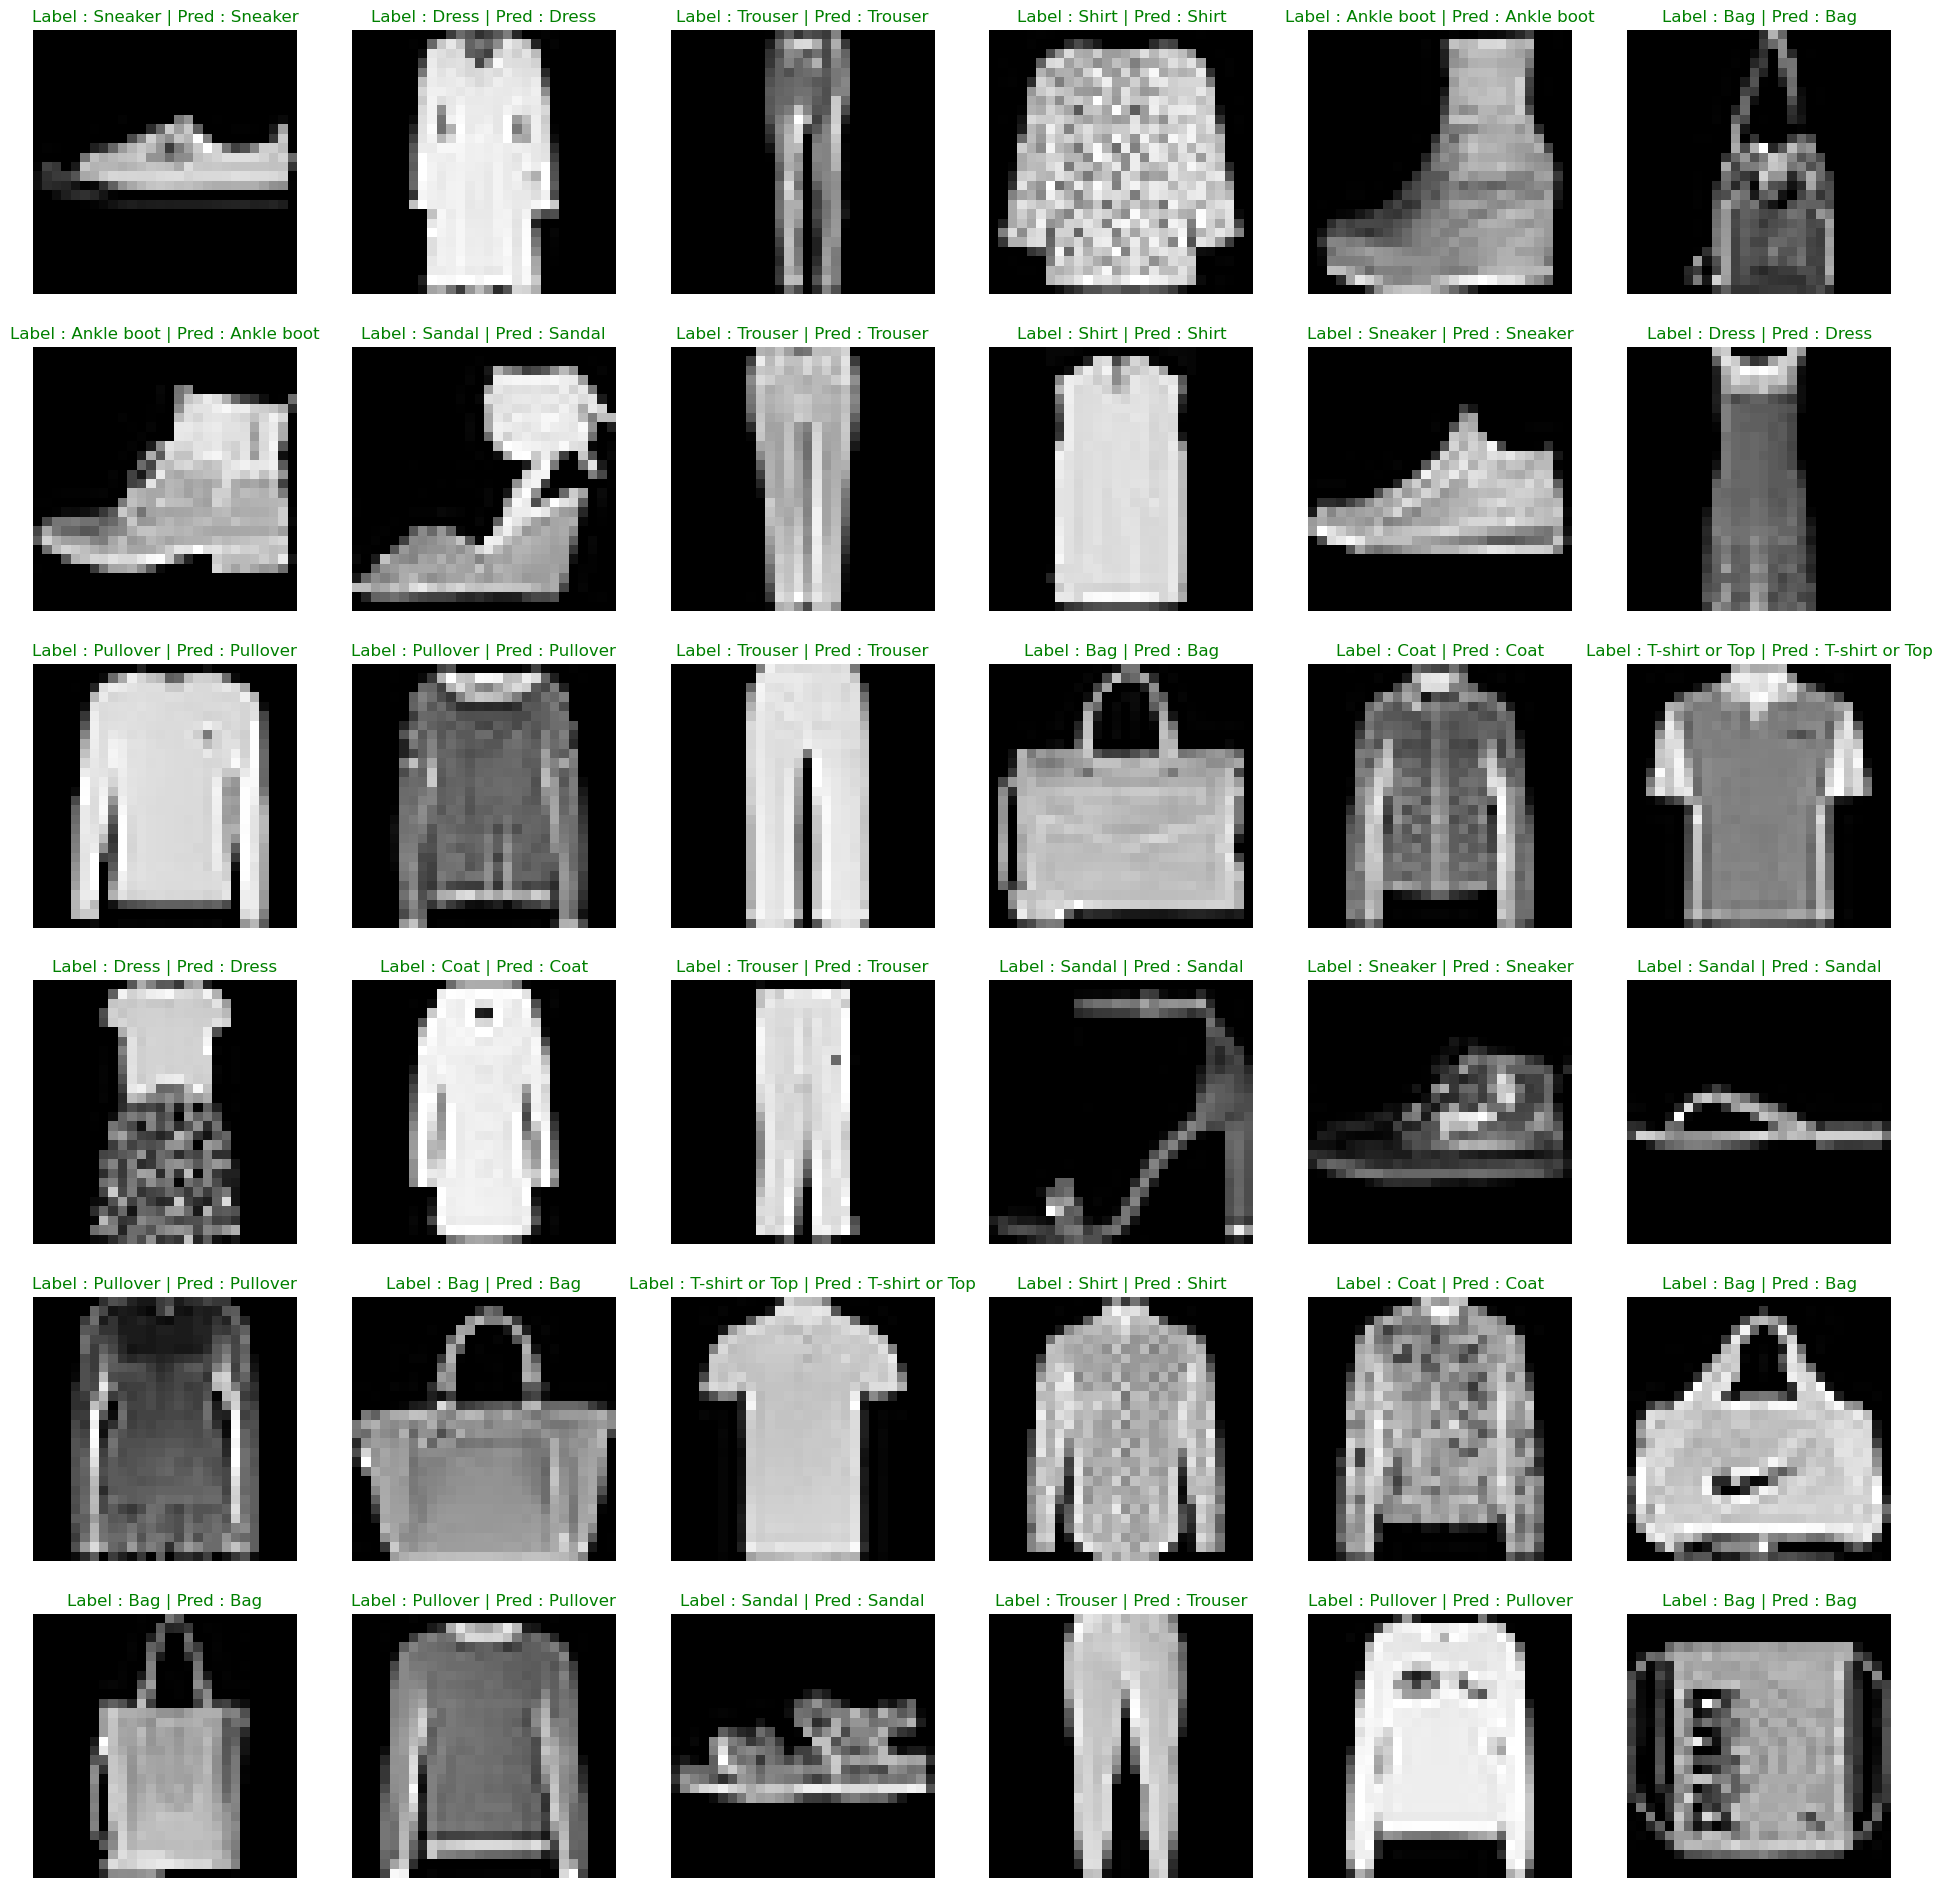

In [22]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28, 28).cpu(), cmap="gray")
    font = {"color" : "r"} if label != pred else {"color" : "g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label : {label} | Pred : {pred}", fontdict=font);
    ax.axis("off");